# Nova evaluation container: Feature examples

This notebook shows how to use the Nova evaluation container to evaluate large language models. You'll work through a support ticket classification example that demonstrates key features for production model evaluation.
|
## What You'll Learn

This notebook covers four main areas:

- **Metadata passthrough**: Keep custom fields (like difficulty level, domain, priority) with your data during evaluation. This lets you see how your model performs on different types of inputs without extra data processing.
- **BYOM (Bring your own metrics)**: Use Lambda functions to validate outputs against your specific requirements. Instead of just checking accuracy, you can verify JSON formatting, business rules, and domain-specific constraints.
- **Confidence & Failure Analysis with logprobs**: Extract token-level probabilities to understand when your model is uncertain. This helps identify overconfident predictions and calibration issues.
- **Multi-Node evalutaion**: Run evaluations across multiple instances to handle large datasets efficiently.

## The Example

You'll evaluate a support ticket classifier using 40 examples with different categories, difficulty levels, and business domains. The notebook shows how to:

- Set up custom Lambda functions for validation
- Configure evaluation recipes with log probabilities
- Launch distributed evaluation jobs on SageMaker
- Analyze results to find specific failure patterns

By the end, you'll understand how to move beyond simple accuracy scores to get detailed insights about where and why your model fails. This approach helps you make 
targeted improvements rather than guessing what needs to be fixed.

The techniques work for any text classification task, but the principles apply to other model types as well.

## Prerequisites

- AWS account with IAM permissions for Lambda, SageMaker, and S3
- SageMaker training instance: `ml.g5.12xlarge` (single or multi-node)
- Nova custom evaluation SDK layer (https://github.com/aws/nova-custom-eval-sdk/releases)
- Nova evaluation container: `708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-HP-Eval-latest` (updated 10/23/25)

This notebook runs locally or in SageMaker Studio. For BYOM workflows, you'll need the custom evaluation layer published to Lambda.

**Note:** This notebook uses the updated evaluation container (10/23/25) with improved logprobs:
- Fixed logprobs count (previously missing ~27% of entries)
- Corrected top logprob values (no longer overwritten)
- Column renamed from `pred_logits` to `pred_logprobs`
- Tokens now include SentencePiece prefix characters (▁) for better context

## Environment Setup

Install SageMaker SDK:

In [1]:
!pip install --upgrade sagemaker
import sagemaker
print(sagemaker.__version__) 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/tsanti/Library/Application Support/sagemaker/config.yaml
2.254.1


Import required libraries:

In [1]:
import json
import pandas as pd
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import boto3
# SageMaker imports
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

print("Environment setup complete")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/tsanti/Library/Application Support/sagemaker/config.yaml
Environment setup complete


## Dataset Preparation with Metadata Passthrough

Metadata passthrough preserves custom fields during evaluation, letting you analyze performance by data segments without additional processing steps.

Standard evaluation gives you overall metrics like 95% accuracy. This doesn't show performance differences across customer types, product categories, or other important dimensions.Without metadata passthrough, you need separate tracking systems and complex data joins after evaluation. This creates extra work and potential data consistency issues.

With metadata passthrough, you can see performance breakdowns immediately. For example, you might find 98% accuracy on billing queries but 60% accuracy on technical support cases.This detailed view helps identify specific problems. You can see patterns like "the model fails on complex logistics cases" or "confidence scores are unreliable for legalcompliance queries." This makes it easier to focus improvements on the right areas.

Metadata passthrough shows you not just whether your model works, but where it works well and where it doesn't. Here we take advantage of this feature to pass metadata fields `category`, `difficulty`, `domain`, and  `priority`

In [2]:
def load_sample_dataset(file_path: str = 'text_eval_dataset.jsonl') -> List[Dict]:
    """Load the sample dataset with metadata"""
    dataset = []
    with open(file_path, 'r') as f:
        for line in f:
            dataset.append(json.loads(line))
    return dataset

def analyze_dataset_metadata(dataset: List[Dict]) -> pd.DataFrame:
    """Analyze metadata distribution in the dataset"""
    metadata_list = []
    for item in dataset:
        metadata = json.loads(item.get('metadata', '{}'))
        metadata_list.append(metadata)
    
    return pd.DataFrame(metadata_list)

# Load and analyze the sample dataset
dataset = load_sample_dataset()
metadata_df = analyze_dataset_metadata(dataset)

print(f"Dataset size: {len(dataset)} examples")
print(f"\nMetadata fields: {list(metadata_df.columns)}")
print(f"\nMetadata distribution:")
for col in metadata_df.columns:
    print(f"{col}: {metadata_df[col].value_counts().to_dict()}")

Dataset size: 40 examples

Metadata fields: ['category', 'difficulty', 'domain', 'priority']

Metadata distribution:
category: {'support_ticket_classification': 40}
difficulty: {'easy': 21, 'medium': 15, 'hard': 4}
domain: {'IT_support': 21, 'billing': 3, 'product': 3, 'account_management': 3, 'security': 2, 'logistics': 2, 'sales': 2, 'technical_account': 1, 'documentation': 1, 'customer_success': 1, 'legal_compliance': 1}
priority: {'medium': 17, 'high': 10, 'low': 7, 'critical': 6}


## Custom Metrics with BYOM Workflow

Without custom metrics, you evaluate models in two separate steps: check general performance, then validate production requirements. This creates a gap where models pass evaluation but fail in production due to format errors or business rule violations.

Bring-your-own-metrics (BYOM) puts your production validation logic into the evaluation pipeline. Instead of relying on accuracy scores alone, you can check that responses follow JSON schemas, meet business constraints, and handle edge cases correctly.

This helps because production failures often come from format issues, not content problems. A model might generate accurate responses that break JSON parsing or miss required fields. Custom metrics catch these problems during evaluation.

The benefit is alignment between evaluation and production. Your evaluation metrics match your production validation logic, so test results better predict real-world performance. BYOM help ensure your model works correctly in your actual system, not just on academic benchmarks.

In [3]:
# Lambda function code for custom metrics (BYOM)
lambda_code = '''
import json
from nova_custom_evaluation_sdk.processors.decorators import preprocess, postprocess
from nova_custom_evaluation_sdk.lambda_handler import build_lambda_handler

@preprocess
def preprocessor(event: dict, context) -> dict:
    data = event.get('data', {})
    return {
        "statusCode": 200,
        "body": {
            "system": data.get("system"),
            "prompt": data.get("prompt", ""),
            "gold": data.get("gold", "")
        }
    }

@postprocess
def postprocessor(event: dict, context) -> dict:
    data = event.get('data', {})
    inference_output = data.get('inference_output', '')
    gold = data.get('gold', '')
    
    metrics = []
    
    # 1. Schema Validation
    schema_valid = validate_schema(inference_output)
    metrics.append({"metric": "schema_validation", "value": 1.0 if schema_valid else 0.0})
    
    # 2. Classification Metrics
    class_metrics = calculate_class_metrics(inference_output, gold)
    metrics.extend(class_metrics)
    
    return {"statusCode": 200, "body": metrics}

def validate_schema(output: str) -> bool:
    try:
        parsed = json.loads(output)
        return "class" in parsed
    except:
        return False

def calculate_class_metrics(inference_output: str, gold: str) -> list:
    pred_class = extract_class(inference_output)
    true_class = extract_class(gold)
    
    if not pred_class or not true_class:
        return [{"metric": "class_accuracy", "value": 0.0}]
    
    accuracy = 1.0 if pred_class.lower() == true_class.lower() else 0.0
    return [{"metric": "class_accuracy", "value": accuracy}]

def extract_class(text: str) -> str:
    try:
        parsed = json.loads(text)
        return str(parsed.get("class", "")).strip()
    except:
        return text.strip()

lambda_handler = build_lambda_handler(
    preprocessor=preprocessor,
    postprocessor=postprocessor
)
'''

print("Custom Lambda function code for BYOM workflow:")
print("- Schema validation metric")
print("- Classification accuracy metric")
print("- Preprocessing and postprocessing hooks")

Custom Lambda function code for BYOM workflow:
- Schema validation metric
- Classification accuracy metric
- Preprocessing and postprocessing hooks


Now lets use this code and create a lambda function with the added layer as shown

## Lambda Function Setup

Rather than embedding custom logic directly in evaluation scripts, the Nova container calls Lambda functions for metric computation. This separation enables version control of evaluation logic, independent scaling of compute resources, and reuse across different evaluation jobs.

The setup involves three components: publishing the Nova evaluation SDK as a Lambda layer, creating an execution role, and deploying the function with custom metrics code.

### Publish Lambda Layer

The Nova custom evaluation SDK provides decorators and utilities for metric computation. Publishing it as a Lambda layer allows reuse across multiple evaluation functions:

In [4]:
import os
import boto3

layer_name = "nova-custom-eval-layer"
zip_file_path = 'nova-custom-eval-layer.zip'

# Get region with fallback
region = os.environ.get('AWS_DEFAULT_REGION') or boto3.Session().region_name or 'us-east-1'
lambda_client = boto3.client('lambda', region_name=region)

if os.path.exists(zip_file_path):
    try:
        with open(zip_file_path, 'rb') as f:
            response = lambda_client.publish_layer_version(
                LayerName=layer_name,
                Content={'ZipFile': f.read()},
                CompatibleRuntimes=['python3.9', 'python3.10', 'python3.11', 'python3.12']
            )
        layer_arn = response['LayerVersionArn']
        print(f"Published layer: {layer_arn}")
    except Exception as e:
        print(f"Error: {e}")
        raise
else:
    # Check for existing layer
    try:
        response = lambda_client.list_layer_versions(LayerName=layer_name, MaxItems=1)
        layer_arn = response['LayerVersions'][0]['LayerVersionArn']
        print(f"Using existing layer: {layer_arn}")
    except:
        raise Exception(f"Layer zip not found. Download from https://github.com/aws/nova-custom-eval-sdk/releases")



Published layer: arn:aws:lambda:us-east-1:975050356504:layer:nova-custom-eval-layer:11


### Create IAM Execution Role

Lambda functions need an execution role to run. This code checks for an existing role and creates one if needed, with a trust policy allowing the Lambda service to assume it and basic execution permissions for CloudWatch logging:

In [5]:
import json
import time
import os
import boto3

# Get region with fallback
region = os.environ.get('AWS_DEFAULT_REGION') or boto3.Session().region_name or 'us-east-1'

iam_client = boto3.client("iam", region_name=region)
lambda_client = boto3.client("lambda", region_name=region)
sts_client = boto3.client("sts", region_name=region)

role_name = "nova-custom-eval-lambda-role"

try:
    account_id = sts_client.get_caller_identity()["Account"]
    lambda_client.list_functions(MaxItems=1)
    
    try:
        role_response = iam_client.get_role(RoleName=role_name)
        role_arn = role_response["Role"]["Arn"]
        print(f"Using existing role: {role_arn}")
    except iam_client.exceptions.NoSuchEntityException:
        trust_policy = {
            "Version": "2012-10-17",
            "Statement": [{
                "Effect": "Allow",
                "Principal": {"Service": "lambda.amazonaws.com"},
                "Action": "sts:AssumeRole"
            }]
        }
        
        role_response = iam_client.create_role(
            RoleName=role_name,
            AssumeRolePolicyDocument=json.dumps(trust_policy),
            Description="Execution role for Nova custom evaluation Lambda"
        )
        
        iam_client.attach_role_policy(
            RoleName=role_name,
            PolicyArn="arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole"
        )
        
        role_arn = role_response["Role"]["Arn"]
        print(f"Created role: {role_arn}")
        time.sleep(10)
        
except Exception as e:
    print(f"Error: {e}")
    raise


Using existing role: arn:aws:iam::975050356504:role/nova-custom-eval-lambda-role


### Deploy Lambda Function

This code packages the custom metrics code into a deployment zip, creates or updates the Lambda function, and attaches the evaluation layer. The function ARN will be used in the evaluation recipe to call our custom metrics:

In [8]:
import boto3
import tempfile
import zipfile
import os
import time

function_name = "nova-custom-eval"
region = os.environ.get('AWS_DEFAULT_REGION') or boto3.Session().region_name or 'us-east-1'

with tempfile.TemporaryDirectory() as tmp_dir:
    lambda_file = os.path.join(tmp_dir, "lambda_function.py")
    with open(lambda_file, "w") as f:
        f.write(lambda_code)
    
    zip_path = os.path.join(tmp_dir, "function.zip")
    with zipfile.ZipFile(zip_path, "w") as z:
        z.write(lambda_file, arcname="lambda_function.py")
    
    with open(zip_path, "rb") as f:
        zip_content = f.read()
    
    lambda_client = boto3.client("lambda", region_name=region)
    
    try:
        lambda_client.get_function(FunctionName=function_name)
        print(f"Updating function {function_name}...")
        response = lambda_client.update_function_code(
            FunctionName=function_name,
            ZipFile=zip_content
        )
    except lambda_client.exceptions.ResourceNotFoundException:
        print(f"Creating function {function_name}...")
        response = lambda_client.create_function(
            FunctionName=function_name,
            Runtime="python3.12",
            Role=role_arn,
            Handler="lambda_function.lambda_handler",
            Code={"ZipFile": zip_content},
            Timeout=30,
            MemorySize=256
        )
    
    # Wait for function to be ready
    while True:
        config = lambda_client.get_function_configuration(FunctionName=function_name)
        if config["LastUpdateStatus"] == "Successful":
            break
        time.sleep(2)
    
    # Update layers - include both custom eval layer and Powertools layer
    # Powertools layer provides Pydantic for structured validation of metric outputs
    powertools_layer_arn = f"arn:aws:lambda:{region}:017000801446:layer:AWSLambdaPowertoolsPythonV3-python312-arm64:1"
    
    response = lambda_client.update_function_configuration(
        FunctionName=function_name,
        Runtime="python3.12",  # Update runtime for existing functions
        Layers=[layer_arn, powertools_layer_arn]
    )
    
    function_arn = response["FunctionArn"]
    print(f"Lambda Function ARN: {function_arn}")

Updating function nova-custom-eval...
Lambda Function ARN: arn:aws:lambda:us-east-1:975050356504:function:nova-custom-eval


### Configure Evaluation Recipe


The recipe YAML defines the complete evaluation pipeline: model selection, inference parameters, and processing configuration. Key settings include `top_logprobs: 10` for confidence analysis and the Lambda ARN for custom metrics processing:

In [9]:
import yaml

recipe_config = {
    "run": {
        "name": "support-ticket-classification",
        "model_type": "amazon.nova-lite-v1:0:300k",
        "model_name_or_path": "nova-lite/prod",
        "replicas": 1
    },
    "evaluation": {
        "task": "gen_qa",
        "strategy": "gen_qa",
        "metric": "all"
    },
    "inference": {
        "max_new_tokens": 2048,
        "temperature": 0,
        "top_logprobs": 10
    },
    "processor": {
        "lambda_arn": function_arn,
        "preprocessing": {"enabled": True},
        "postprocessing": {"enabled": True},
        "aggregation": "average"
    }
}

with open("lambda_recipe.yaml", "w") as f:
    yaml.dump(recipe_config, f, default_flow_style=False, sort_keys=False)

print(f"Recipe saved with Lambda ARN: {function_arn}")


Recipe saved with Lambda ARN: arn:aws:lambda:us-east-1:975050356504:function:nova-custom-eval


## Launch SageMaker Evaluation Job

SageMaker provides the compute infrastructure and container orchestration for Nova evaluations. The training job abstraction handles resource provisioning, data loading, and result collection. Critical configuration includes the Nova container image, compute instance type, and S3 paths for input data and output results.

The training job configuration specifies the Nova container image, instance type, and S3 locations. Key parameters include the evaluation recipe path, input dataset location, and output directory for results. Update the `input_s3_uri`, `output_s3_uri`, and `role` fields to match your AWS environment before execution. Ensure your dataset is uploaded to the S3 location specified in `input_s3_uri`.


In [10]:
import os
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()

# Use your actual SageMaker execution role ARN
role = "arn:aws:iam::975050356504:role/service-role/AmazonSageMaker-ExecutionRole-20240404T210962"

input_s3_uri = "s3://kb-doc-bucket-2025/Input/text_eval_dataset.jsonl"
output_s3_uri = "s3://kb-doc-bucket-2025/output/"

estimator = PyTorch(
    output_path=output_s3_uri,
    base_job_name="support-ticket-classification",
    role=role,
    instance_type="ml.g5.12xlarge",
    training_recipe="lambda_recipe.yaml",
    sagemaker_session=sagemaker_session,
    image_uri="708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-HP-Eval-latest"
    
)

print(f"Using role: {role}")
estimator.fit(inputs={"train": TrainingInput(s3_data=input_s3_uri)})

Using role: arn:aws:iam::975050356504:role/service-role/AmazonSageMaker-ExecutionRole-20240404T210962


INFO:sagemaker:Creating training-job with name: support-ticket-classification-2025-11-06-23-53-11-022


2025-11-06 23:53:12 Starting - Starting the training job
2025-11-06 23:53:12 Pending - Training job waiting for capacity.........
2025-11-06 23:54:47 Downloading - Downloading input data.................................
2025-11-07 00:00:05 Downloading - Downloading the training image............
2025-11-07 00:02:27 Training - Training image download completed. Training in progress.../usr/local/lib/python3.12/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
2025-11-07 00:02:35,031 - IN

Evaluation runtime depends on dataset size, model complexity, and instance type. The 40-example dataset typically completes in 20-40 minutes on `ml.g5.12xlarge` instances.

## Review Evaluation Results

The evaluation outputs include comprehensive metrics, individual predictions, and token-level log probabilities stored in the S3 output directory. These results enable detailed performance analysis and confidence-based failure investigation.


In [11]:
def load_parquet_file(file_path):
    """
    Load a parquet file into a pandas DataFrame
    
    Args:
        file_path (str): Path to the parquet file
        
    Returns:
        pandas.DataFrame: The loaded DataFrame
    """
    try:
        # Read the parquet file
        df = pd.read_parquet(file_path)
        return df
    except Exception as e:
        print(f"Error loading parquet file: {e}")
        return None

Download, extract, and load evaluation results from S3, including detailed metrics, predictions, and log probabilities for analysis.


In [12]:
import boto3
import os
import tarfile
import glob

def download_and_extract_output(output_s3_uri, job_name, output_dir='./evaluation_results'):
    """
    Download output.tar.gz from S3 and extract it to a local directory.
    Returns the path to the parquet results file.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    if output_s3_uri.startswith('s3://'):
        output_s3_uri = output_s3_uri[5:]
    
    if output_s3_uri.endswith('/'):
        output_s3_uri = output_s3_uri[:-1]
    
    parts = output_s3_uri.split('/')
    bucket = parts[0]
    prefix = '/'.join(parts[1:])
    
    s3_key = f"{prefix}/{job_name}/output/output.tar.gz"
    local_tar_path = os.path.join(output_dir, "output.tar.gz")
    
    print(f"Downloading from s3://{bucket}/{s3_key} to {local_tar_path}")
    
    s3_client = boto3.client('s3')
    
    try:
        s3_client.download_file(bucket, s3_key, local_tar_path)
        print("Download completed successfully")
        
        print(f"Extracting to {output_dir}")
        with tarfile.open(local_tar_path, "r:gz") as tar:
            tar.extractall(path=output_dir)
        print("Extraction completed successfully")
        
        os.remove(local_tar_path)
        print(f"Removed {local_tar_path}")
        
        # Find the parquet file
        parquet_pattern = os.path.join(output_dir, "**", "*.parquet")
        parquet_files = glob.glob(parquet_pattern, recursive=True)
        
        if parquet_files:
            results_path = parquet_files[0]
            print(f"\nResults parquet file: {results_path}")
            return results_path
        else:
            print("Warning: No parquet file found")
            return None
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [13]:
# Get the job name from the estimator you just ran
job_name = estimator.latest_training_job.name
print(f"Latest job name: {job_name}")

# Download the results - returns path to parquet file
parquet_path = download_and_extract_output(
    output_s3_uri=output_s3_uri,
    job_name=job_name,
    output_dir='./evaluation_results_new'
)

# Load the parquet file directly
if parquet_path:
    results_df = pd.read_parquet(parquet_path)
    print(f"Loaded {len(results_df)} rows from results")
    print("Columns:", results_df.columns.tolist())
else:
    print("Failed to load results - no parquet file found")


Latest job name: support-ticket-classification-2025-11-06-23-53-11-022
Download completed successfully
Extracting to ./evaluation_results_new
Extraction completed successfully
Removed ./evaluation_results_new/output.tar.gz

Results parquet file: ./evaluation_results_new/support-ticket-classification/eval_results/details/model/2025-11-06T17-58-52.783156+00-00/details_custom|gen_qa_gen_qa|0_2025-11-06T17-58-52.783156+00-00.parquet
Loaded 40 rows from results
Columns: ['choices', 'cont_tokens', 'example', 'full_prompt', 'gold', 'gold_index', 'input_tokens', 'instruction', 'metrics', 'num_asked_few_shots', 'num_effective_few_shots', 'padded', 'pred_logprobs', 'prediction_logits', 'predictions', 'specifics', 'truncated']


/var/folders/fb/jwvjkxj13zg7fhvzfgl8_hg40000gq/T/ipykernel_14667/1191997785.py:36: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_dir)


#### Evaluation Results Structure

The Nova container outputs structured results to the S3 path specified in the recipe configuration. The output directory contains evaluation metrics, detailed predictions, and TensorBoard logs organized in the following hierarchy:


```
job_name/
├── eval-results/
│    └── results_[timestamp].json
│    └── inference_output.jsonl (only present for gen_qa)
│    └── details/
│        └── model/
│            └── execution-date-time/
│                └──details_task_name_#_datetime.parquet
└── tensorboard-results/
    └── eval/
        └── events.out.tfevents.[timestamp]
```

## Failure Analysis with Log Probabilities

This section implements confidence analysis with raw model prediction logits into actionable insights. We examine the relationship between model confidence and prediction quality to identify failure patterns that could compromise model trustworthiness. For our classifcation use case we can simply look at the first token of the classification string as our classes do not all start with the same tokens. This eliminates the complexity of combining tokens and probabilities then calculating a mean to be used in downstream scoring.


The analysis covers:

- **Confidence extraction**: Convert prediction logits into confidence scores
- **Failure detection**: Identify overconfident or uncertain predictions  
- **Visualization**: Create charts to show model reliability patterns

Components:

- **Logit processing**: Parse prediction data and handle different formats
- **Token analysis**: Extract prediction tokens and calculate probabilities
- **Failure classification**: Find low-confidence predictions and overconfident errors

This analysis shows:
- How to extract confidence metrics from model outputs
- Which patterns indicate model failures
- How to visualize confidence data
- When confidence scores match actual performance

In [14]:
import json
import numpy as np
import pandas as pd
import ast
import re


def calculate_confidence_score(pred_logprobs_str, prediction_text="") -> tuple:
    """
    Calculate confidence score from log probabilities for the predicted class.
    
    Args:
        pred_logprobs_str (str): String representation of prediction logprobs (updated field name as of 10/23/25)
        prediction_text (str): The actual prediction text to extract class from
        
    Returns:
        tuple: (confidence, predicted_token, filtered_keys) - 
               confidence: The first token probability of the predicted class
               predicted_token: The predicted class name
               filtered_keys: List of tokens in the class name
    
    Note: Tokens may include SentencePiece prefix characters (▁) as of container update 10/23/25
    """
    if not pred_logprobs_str or pred_logprobs_str == '[]':
        return 0.0, "", []
    
    try:
        # Extract the predicted class from the prediction text
        predicted_class = ""
        if prediction_text:
            try:
                parsed = json.loads(prediction_text)
                predicted_class = str(parsed.get("class", "")).strip()
            except:
                predicted_class = ""
        
        if not predicted_class:
            return 0.0, "", []
        
        logprobs = ast.literal_eval(pred_logprobs_str)
        if not logprobs or len(logprobs) == 0:
            return 0.0, predicted_class, []
        
        # Build dictionary of all tokens and their probabilities
        token_probs = {}
        for token_prob_dict in logprobs[0]:
            if isinstance(token_prob_dict, dict) and token_prob_dict:
                max_key = max(token_prob_dict.items(), key=lambda x: x[1])[0]
                max_logprob = token_prob_dict[max_key]
                token_probs[max_key] = np.exp(max_logprob)
        
        # Find tokens that match the predicted class
        class_tokens = []
        class_probs = []
        
        # Split class name into potential tokens
        class_parts = re.split(r'[_\s]+', predicted_class)
        
        for token, prob in token_probs.items():
            # Strip SentencePiece prefix (▁) and other special characters for matching
            clean_token = re.sub(r'[^a-zA-Z0-9]', '', token)
            if clean_token:
                # Check if this token matches any part of the class name
                for part in class_parts:
                    if part and (clean_token.lower() == part.lower() or 
                                part.lower().startswith(clean_token.lower()) or
                                clean_token.lower().startswith(part.lower())):
                        class_tokens.append(clean_token)
                        class_probs.append(prob)
                        break
        
        # Use first token confidence (OpenAI's classification approach)
        if class_probs:
            confidence = float(class_probs[0])
        else:
            confidence = 0.0
        
        return confidence, predicted_class, class_tokens
    except Exception as e:
        print(f"Error processing log probs: {e}")
        return 0.0, "", []


def analyze_low_confidence_failures(results_df: pd.DataFrame, confidence_threshold: float = 0.7, quality_threshold: float = 0.3) -> dict:
    """Perform comprehensive failure analysis"""
    
    # Make a copy to avoid modifying original
    df = results_df.copy()
    
    # Helper to extract prediction text
    def get_prediction_text(row):
        pred = row['predictions']
        
        # Handle string representation of array: "['text']" 
        if isinstance(pred, str):
            try:
                pred_list = ast.literal_eval(pred)
                if isinstance(pred_list, list) and len(pred_list) > 0:
                    return str(pred_list[0]).strip()
            except:
                pass
        
        # Handle actual array
        if isinstance(pred, (list, np.ndarray)) and len(pred) > 0:
            return str(pred[0]).strip()
        
        return str(pred).strip()
    
    # Apply the function with both logprobs and prediction text
    confidence_results = df.apply(
        lambda row: calculate_confidence_score(row['pred_logprobs'], get_prediction_text(row)), 
        axis=1
    )
    df[['confidence', 'predicted_token', 'filtered_keys']] = pd.DataFrame(
        list(confidence_results), 
        index=df.index,
        columns=['confidence', 'predicted_token', 'filtered_keys']
    )
    
    df['quality_score'] = df['metrics'].apply(
        lambda x: ast.literal_eval(x).get('f1', 0) if x else 0
    )
    df['is_correct'] = df['quality_score'] >= quality_threshold
    
    # Analyze low confidence predictions
    low_conf_df = df[df['confidence'] < confidence_threshold]
    
    # Also identify high confidence but low quality (overconfident errors)
    overconfident_df = df[(df['confidence'] >= confidence_threshold) & 
                          (df['quality_score'] < quality_threshold)]
    
    analysis_results = {
        'summary': {
            'total_predictions': len(df),
            'low_confidence_count': len(low_conf_df),
            'low_confidence_rate': len(low_conf_df) / len(df) if len(df) > 0 else 0,
            'overconfident_errors': len(overconfident_df),
            'overconfident_rate': len(overconfident_df) / len(df) if len(df) > 0 else 0,
            'avg_confidence': df['confidence'].mean(),
            'avg_quality': df['quality_score'].mean(),
            'overall_accuracy': df['is_correct'].mean()
        },
        'low_confidence_examples': [],
        'overconfident_examples': []
    }
    
    # Low confidence examples
    if len(low_conf_df) > 0:
        for idx, row in low_conf_df.iterrows():
            try:
                specifics = ast.literal_eval(row['specifics'])
                metadata = json.loads(specifics.get('metadata', '{}'))
                
                analysis_results['low_confidence_examples'].append({
                    'example': row['example'][:100] + '...' if len(row['example']) > 100 else row['example'],
                    'confidence': row['confidence'],
                    'quality_score': row['quality_score'],
                    'category': metadata.get('category', 'unknown'),
                    'difficulty': metadata.get('difficulty', 'unknown'),
                    'domain': metadata.get('domain', 'unknown')
                })
            except:
                pass
    
    # Overconfident errors
    if len(overconfident_df) > 0:
        for idx, row in overconfident_df.iterrows():
            try:
                specifics = ast.literal_eval(row['specifics'])
                metadata = json.loads(specifics.get('metadata', '{}'))
                
                analysis_results['overconfident_examples'].append({
                    'example': row['example'][:100] + '...' if len(row['example']) > 100 else row['example'],
                    'confidence': row['confidence'],
                    'quality_score': row['quality_score'],
                    'category': metadata.get('category', 'unknown'),
                    'difficulty': metadata.get('difficulty', 'unknown'),
                    'domain': metadata.get('domain', 'unknown')
                })
            except:
                pass
    
    return analysis_results


# Use already loaded data
analysis_results = analyze_low_confidence_failures(results_df, confidence_threshold=0.7, quality_threshold=0.3)

print("=" * 60)
print("FAILURE ANALYSIS RESULTS")
print("=" * 60)
print(f"\nTotal predictions: {analysis_results['summary']['total_predictions']}")
print(f"Average confidence: {analysis_results['summary']['avg_confidence']:.3f}")
print(f"Average F1 quality: {analysis_results['summary']['avg_quality']:.3f}")
print(f"Overall accuracy (F1>0.3): {analysis_results['summary']['overall_accuracy']:.1%}")

print(f"\n{'=' * 60}")
print("LOW CONFIDENCE PREDICTIONS (confidence < 0.7)")
print("=" * 60)
print(f"Count: {analysis_results['summary']['low_confidence_count']} ({analysis_results['summary']['low_confidence_rate']:.1%})")
for i, example in enumerate(analysis_results['low_confidence_examples'][:5], 1):
    print(f"\n{i}. Confidence: {example['confidence']:.3f} | F1: {example['quality_score']:.3f}")
    print(f"   {example['difficulty']} | {example['domain']}")
    print(f"   {example['example']}")

print(f"\n{'=' * 60}")
print("OVERCONFIDENT ERRORS (confidence >= 0.7 but F1 < 0.3)")
print("=" * 60)
print(f"Count: {analysis_results['summary']['overconfident_errors']} ({analysis_results['summary']['overconfident_rate']:.1%})")
for i, example in enumerate(analysis_results['overconfident_examples'][:5], 1):
    print(f"\n{i}. Confidence: {example['confidence']:.3f} | F1: {example['quality_score']:.3f}")
    print(f"   {example['difficulty']} | {example['domain']}")
    print(f"   {example['example']}")

FAILURE ANALYSIS RESULTS

Total predictions: 40
Average confidence: 0.863
Average F1 quality: 0.248
Overall accuracy (F1>0.3): 30.0%

LOW CONFIDENCE PREDICTIONS (confidence < 0.7)
Count: 9 (22.5%)

1. Confidence: 0.543 | F1: 0.179
   medium | IT_support
   Email notifications stopped working yesterday. I'm not receiving any alerts for new messages, mentio...

2. Confidence: 0.562 | F1: 0.308
   easy | IT_support
   How do I set up two-factor authentication on my account? I've looked through the settings but can't ...

3. Confidence: 0.598 | F1: 0.272
   easy | IT_support
   I'm getting a 'Disk quota exceeded' message. I've deleted several files but the message persists. Ho...

4. Confidence: 0.393 | F1: 0.341
   hard | IT_support
   Database backup failed last night with error code DB_ERR_1045. This is the third consecutive night o...

5. Confidence: 0.473 | F1: 0.232
   medium | technical_account
   API rate limiting is blocking our integration. We're hitting the limit within the firs

## Helper Functions for Result Parsing

Model evaluation systems produce messy data. Predictions come wrapped in JSON strings, nested arrays, or Python literals depending on which framework generated them. Before we can analyze confidence patterns, we need to extract the actual predictions and probability scores from these varied formats.

Our parsing functions handle three main tasks:

- **Data Format Conversion**: Transform JSON strings, Python literals, and nested arrays into consistent structures for analysis.
- **Information Extraction**: Pull class predictions, confidence scores, and metadata from evaluation results.
- **Error Recovery**: Deal with malformed data, missing fields, and parsing failures that happen in real evaluation pipelines.

What looks like simple parsing actually solves a practical problem: evaluation systems rarely produce data in the same format twice. Different models, frameworks, and even individual predictions can generate outputs in completely different structures. Our functions need to handle this variation while extracting consistent data for analysis.

In [15]:
import re
import json

def extract_gold(text):
    """
    More robust extraction handling various formats and bytes
    """
    is_bytes = isinstance(text, bytes)
    
    if is_bytes:
        patterns = [
            rb'"class"\s*:\s*"([^"]+)"',
            rb'"class"\s*:\s*([^,}\s]+)',
            rb"'class'\s*:\s*'([^']+)'",
            rb"'class'\s*:\s*([^,}\s]+)",
        ]
        
        for pattern in patterns:
            match = re.search(pattern, text)
            if match:
                value = match.group(1).decode('utf-8', errors='ignore').strip()
                value = re.sub(r'[.,;]+$', '', value)
                return value
    else:
        patterns = [
            r'"class"\s*:\s*"([^"]+)"',
            r'"class"\s*:\s*([^,}\s]+)',
            r"'class'\s*:\s*'([^']+)'",
            r"'class'\s*:\s*([^,}\s]+)",
        ]
        
        for pattern in patterns:
            match = re.search(pattern, text)
            if match:
                value = match.group(1).strip()
                value = re.sub(r'[.,;]+$', '', value)
                return value
    
    return None

def parse_preds(text):
    """
    Parse a malformed JSON string into a dictionary
    """
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')
    
    text = text.strip()
    if text.startswith('[') and text.endswith(']'):
        text = text[1:-1].strip()
    
    if (text.startswith("'") and text.endswith("'")) or \
       (text.startswith('"') and text.endswith('"')):
        text = text[1:-1]
    
    text = text.replace('\\n', '\n')
    text = text.replace('\\"', '"')
    
    try:
        return json.loads(text)
    except json.JSONDecodeError as e:
        result = {}
        
        class_match = re.search(r'"class"\s*:\s*"([^"]+)"', text)
        if class_match:
            result['class'] = class_match.group(1)
        
        thought_match = re.search(r'"thought"\s*:\s*"([^"]+)"', text)
        if thought_match:
            result['thought'] = thought_match.group(1)
        
        desc_match = re.search(r'"description"\s*:\s*"([^"]+)"', text)
        if desc_match:
            result['description'] = desc_match.group(1)
        
        return result if result else None

# Success confirmation
print("✓ Helper functions defined successfully:")
print("  - extract_gold(): Extracts class from gold standard")
print("  - parse_preds(): Parses prediction text to dict")
print("\nFunctions are ready to use for data processing.")

✓ Helper functions defined successfully:
  - extract_gold(): Extracts class from gold standard
  - parse_preds(): Parses prediction text to dict

Functions are ready to use for data processing.


These functions transform raw log probability strings into meaningful confidence scores. The `parse_log_probs` function extracts token-level probability information from the model's output, handling the nested dictionary format that contains each token's likelihood.

The `find_target_tokens` function addresses a key challenge: class names like "Software_Bug" might be tokenized as multiple pieces. We need to find all possible token representations to accurately calculate confidence scores.

The `extract_class_confidence` function brings everything together, searching through the probability sequence to find tokens matching our target class. When multiple tokens are found, it uses geometric mean to combine their probabilities—a more statistically sound approach than simple multiplication. This gives us reliable confidence scores that reflect the model's actual uncertainty about its predictions.

In [16]:
import re
import math
import ast
import json

def parse_log_probs(data_str):
    """Parse the log probability data string into a list of token dictionaries"""
    pattern = r"\{([^}]+)\}"
    matches = re.findall(pattern, data_str)
    
    parsed_sequence = []
    for match in matches:
        pairs = re.findall(r"'([^']+)':\s*([-\d.e]+)", match)
        token_dict = {token: float(log_prob) for token, log_prob in pairs}
        parsed_sequence.append(token_dict)
    
    return parsed_sequence

def find_target_tokens(target_class):
    """Split target class into component tokens"""
    tokens = []
    
    if '_' in target_class:
        parts = target_class.split('_')
        for i, part in enumerate(parts):
            if i > 0:
                tokens.append('_')
            subtokens = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z][a-z]|\b)', part)
            tokens.extend(subtokens)
    else:
        tokens = re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z][a-z]|\b)', target_class)
    
    return [target_class] + tokens

def extract_class_confidence(data_str, target_class, use_first_occurrence=True):
    """Extract confidence score for target class prediction.
    
    Args:
        data_str: Log probability data string
        target_class: Target class to find
        use_first_occurrence: If True, only use first match of each token (default: True)
    
    Returns:
        Dict with confidence metrics using geometric mean for multi-token sequences
    """
    parsed_sequence = parse_log_probs(data_str)
    possible_tokens = find_target_tokens(target_class)
    
    print(f"Searching for target class: '{target_class}'")
    print(f"Possible token sequences: {possible_tokens}\n")
    
    # Track which tokens we've found and at what positions
    found_tokens = []
    used_positions = set()
    
    # Search for tokens in order, using first occurrence only
    for token in possible_tokens:
        for step_idx, token_dict in enumerate(parsed_sequence):
            if use_first_occurrence and step_idx in used_positions:
                continue
            if token in token_dict:
                log_prob = token_dict[token]
                prob = math.exp(log_prob)
                found_tokens.append({
                    'step': step_idx,
                    'token': token,
                    'log_prob': log_prob,
                    'probability': prob,
                    'confidence_pct': prob * 100
                })
                used_positions.add(step_idx)
                break  # Use first occurrence of this token
    
    if not found_tokens:
        print(f"❌ Target class '{target_class}' not found in sequence")
        return None
    
    if len(found_tokens) == 1:
        result = found_tokens[0]
        print("=" * 70)
        print(f"✓ FOUND: '{target_class}' as single token")
        print("=" * 70)
        print(f"Step: {result['step']}")
        print(f"Log Probability: {result['log_prob']:.10f}")
        print(f"Confidence: {result['confidence_pct']:.6f}%")
        print("=" * 70)
        return result
    else:
        print("=" * 70)
        print(f"✓ FOUND: '{target_class}' as token sequence")
        print("=" * 70)
        
        # Use geometric mean (via log space) instead of multiplying probabilities
        log_probs = [t['log_prob'] for t in found_tokens]
        mean_log_prob = np.mean(log_probs)
        overall_prob = np.exp(mean_log_prob)
        
        for token_info in found_tokens:
            print(f"  Step {token_info['step']:2d} | '{token_info['token']:12s}' | "
                  f"Confidence: {token_info['confidence_pct']:8.4f}%")
        
        print("-" * 70)
        print(f"Geometric Mean Confidence: {overall_prob*100:.6f}%")
        print(f"Mean Log Probability: {mean_log_prob:.10f}")
        print("=" * 70)
        
        return {
            'tokens': found_tokens,
            'overall_probability': overall_prob,
            'overall_log_prob': mean_log_prob,
            'confidence_pct': overall_prob * 100
        }

def parse_to_dict(text):
    """Parse a malformed JSON string into a dictionary"""
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')
    
    original_text = text
    text = text.strip()
    
    if text.startswith('[') and text.endswith(']'):
        text = text[1:-1].strip()
    
    if (text.startswith("'") and text.endswith("'")) or \
       (text.startswith('"') and text.endswith('"')):
        text = text[1:-1]
    
    try:
        result = ast.literal_eval(original_text)
        if isinstance(result, dict):
            for key, value in result.items():
                if isinstance(value, str) and (value.strip().startswith('{') or value.strip().startswith('[')):
                    try:
                        result[key] = json.loads(value)
                    except:
                        pass
            return result
    except (ValueError, SyntaxError):
        pass
    
    text = text.replace('\\n', '\n')
    text = text.replace('\\"', '"')
    text = text.replace("\\'", "'")
    
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        pass
    
    result = {}
    patterns = [
        r'"(\w+)"\s*:\s*"([^"]*)"',
        r"'(\w+)'\s*:\s*'([^']*)'",
        r'"(\w+)"\s*:\s*({[^}]+})',
        r"'(\w+)'\s*:\s*({[^}]+})",
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, text, re.DOTALL)
        for key, value in matches:
            if value.strip().startswith('{'):
                try:
                    result[key] = json.loads(value.replace("'", '"'))
                except:
                    result[key] = value
            else:
                result[key] = value
    
    return result if result else None

# Success confirmation
print("✓ Log probability and parsing functions defined successfully:")
print("  - parse_log_probs(): Parses log probability strings")
print("  - find_target_tokens(): Tokenizes target class names")
print("  - extract_class_confidence(): Extracts confidence for predictions")
print("  - parse_to_dict(): Parses malformed JSON/dict strings")
print("\nAll functions are ready for confidence analysis and data processing.")


✓ Log probability and parsing functions defined successfully:
  - parse_log_probs(): Parses log probability strings
  - find_target_tokens(): Tokenizes target class names
  - extract_class_confidence(): Extracts confidence for predictions
  - parse_to_dict(): Parses malformed JSON/dict strings

All functions are ready for confidence analysis and data processing.



This function handles the final step in our data extraction pipeline: pulling the actual class predictions from various output formats. Unlike the previous functions that dealt with raw parsing, `extract_class_value` focuses specifically on finding class labels regardless of how they're wrapped or formatted.

The function demonstrates the messy reality of model outputs. Predictions might come as:
- String representations of Python lists: `"['Document_Request']"`
- NumPy arrays from batch processing  
- Clean JSON dictionaries: `{"class": "Document_Request"}`
- Markdown-formatted text: `**Issue Type:** Document Request`
- Raw strings with various quote styles

Each format requires a different extraction strategy. The function tries the most structured approaches first (JSON parsing), then falls back to regex patterns for less structured text. This cascading approach ensures we can extract class labels from virtually any output format while maintaining accuracy.

The test section validates our extraction logic against real evaluation data, showing how the same function handles both prediction and gold standard formats. This verification step is crucial—if we can't reliably extract class labels, our entire accuracy analysis becomes meaningless.


In [17]:
import ast
import re
import json

def extract_class_value(text):
    """Extract class value from various text formats"""
    # Handle string representation of list: "['...']"
    if isinstance(text, str) and text.startswith('['):
        try:
            parsed_list = ast.literal_eval(text)
            if isinstance(parsed_list, list) and len(parsed_list) > 0:
                text = parsed_list[0]
        except:
            pass
    
    # Handle numpy array
    if isinstance(text, np.ndarray) and len(text) > 0:
        text = text[0]
    
    # Convert to string
    text = str(text)
    
    # Try JSON format: {"class": "Document_Request"}
    try:
        parsed = json.loads(text)
        if isinstance(parsed, dict) and 'class' in parsed:
            return parsed['class']
    except:
        pass
    
    # Try markdown format: **Issue Type:** Document Request
    patterns = [
        r'\*\*Issue Type:\*\*\s*([^\n]+)',
        r'Issue Type:\s*([^\n]+)',
        r'"class"\s*:\s*"([^"]+)"',
        r"'class'\s*:\s*'([^']+)'",
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            value = match.group(1).strip()
            # Clean up common suffixes
            value = re.sub(r'\s*/\s*.*$', '', value)  # Remove "/ Department" part
            return value
    
    return None

# Test it
print("Testing extraction:")
pred_sample = results_df['predictions'].iloc[0]
gold_sample = results_df['gold'].iloc[0]

print(f"Prediction extracted: {extract_class_value(pred_sample)}")
print(f"Gold extracted: {extract_class_value(gold_sample)}")

Testing extraction:
Prediction extracted: Billing_Issue
Gold extracted: User_Guidance


Let's Preview the analysis results showing predictions, gold labels, correctness, confidence scores, and metadata for the first few samples. 

In [18]:
results_df.head()

,choices,cont_tokens,example,full_prompt,gold,gold_index,input_tokens,instruction,metrics,num_asked_few_shots,num_effective_few_shots,padded,pred_logprobs,prediction_logits,predictions,specifics,truncated
0,[],[[]],My order #45821 was supposed to arrive yesterd...,"[{'role': 'system', 'content': 'You are a supp...","[{""class"": ""User_Guidance"", ""thought"": ""Delive...",[],[[]],,"{'rouge1': 0.12658227848101267, 'rouge2': 0.0,...",0,0,[0],"[[{'▁{\n': -0.22616860270500183, '▁{""': -1.601...",[],"[' {\n""class"": ""Billing_Issue"",\n""thought"": ""T...",{'system_prompt': 'You are a support ticket cl...,[0]
1,[],[[]],I was charged twice for my subscription this m...,"[{'role': 'system', 'content': 'You are a supp...","[{""class"": ""Billing_Issue"", ""thought"": ""Duplic...",[],[[]],,"{'rouge1': 0.37362637362637363, 'rouge2': 0.11...",0,0,[0],"[[{'▁{\n': -0.11298973858356476, '▁{""': -2.237...",[],"[' {\n""class"": ""Billing_Issue"",\n""thought"": ""T...",{'system_prompt': 'You are a support ticket cl...,[0]
2,[],[[]],The data synchronization between our CRM and e...,"[{'role': 'system', 'content': 'You are a supp...","[{""class"": ""Software_Bug"", ""thought"": ""Integra...",[],[[]],,"{'rouge1': 0.4266666666666667, 'rouge2': 0.219...",0,0,[0],"[[{'▁{\n': -0.16171115636825562, '▁{""': -1.911...",[],"[' {\n""class"": ""Software_Bug"",\n""thought"": ""Th...",{'system_prompt': 'You are a support ticket cl...,[0]
3,[],[[]],The graphs and charts in reports are displayin...,"[{'role': 'system', 'content': 'You are a supp...","[{""class"": ""Software_Bug"", ""thought"": ""Discrep...",[],[[]],,"{'rouge1': 0.2784810126582279, 'rouge2': 0.077...",0,0,[0],"[[{'▁{\n': -0.10056283324956894, '▁{""': -2.350...",[],"[' {\n""class"": ""Software_Bug"",\n""thought"": ""Th...",{'system_prompt': 'You are a support ticket cl...,[0]
4,[],[[]],Email notifications stopped working yesterday....,"[{'role': 'system', 'content': 'You are a supp...","[{""class"": ""Software_Bug"", ""thought"": ""Complet...",[],[[]],,"{'rouge1': 0.21874999999999997, 'rouge2': 0.0,...",0,0,[0],"[[{'▁{\n': -0.2023947834968567, '▁{""': -1.7023...",[],"[' {\n""class"": ""Network_Critical"",\n""thought"":...",{'system_prompt': 'You are a support ticket cl...,[0]


### Multi-Node Scaling (optional)

Optionally you can scale evaluation to larger datasets using **multi-node evaluation** by simply increasing the replica count.

In [19]:
# Multi-node configuration - just change the replicas parameter
multinode_config = {
    "run": {
        "name": "support-ticket-classification-multinode",
        "model_name_or_path": "nova-lite-v1:0",
        "replicas": 4  # Scale to 4 nodes automatically you must have quota allocation for this
    },
    "evaluation": {
        "task": "gen_qa",
        "strategy": "gen_qa",
        "metric": "all"
    },
    "inference": {
        "max_new_tokens": 2048,
        "temperature": 0,
        "top_logprobs": 10
    }
}

print("Multi-node scaling configuration:")
print(f"Replicas: {multinode_config['run']['replicas']}")
print("\nBenefits:")
print("- Automatic workload distribution")
print("- Preserved metadata-based analysis")
print("- Deterministic result aggregation")
print("- Scale from thousands to millions of examples")

Multi-node scaling configuration:
Replicas: 4

Benefits:
- Automatic workload distribution
- Preserved metadata-based analysis
- Deterministic result aggregation
- Scale from thousands to millions of examples


## Results Visualization and Performance Analysis

Moving beyond aggregate metrics requires systematic analysis of model behavior patterns. This comprehensive visualization framework transforms raw evaluation data into actionable intelligence by examining performance through multiple analytical lenses.

Let's xamine four critical performance dimensions:

**Confidence Calibration Analysis**: Model confidence scores reveal calibration quality - well-calibrated models show strong correlation between confidence and accuracy. Poor calibration indicates overconfident predictions on incorrect outputs, suggesting need for confidence penalty training or temperature scaling.

**Domain-Specific Performance Patterns**: Different domains (IT support, billing, security) exhibit varying complexity levels and linguistic patterns. Performance gaps across domains indicate training data imbalances or domain-specific feature requirements.

**Difficulty-Accuracy Relationships**: The relationship between labeled difficulty and model performance reveals whether the model struggles with inherently complex cases or exhibits systematic biases independent of true difficulty.

**Metadata Cross-Tabulation**: Examining performance at metadata intersections (e.g., hard IT support tickets vs. easy billing queries) identifies compound failure modes where multiple factors interact to degrade performance.

In [20]:
import ast
import json
import re

# Helper function to get prediction text
def get_prediction_text(row):
    pred = row['predictions']
    if isinstance(pred, str):
        try:
            pred_list = ast.literal_eval(pred)
            if isinstance(pred_list, list) and len(pred_list) > 0:
                return str(pred_list[0]).strip()
        except:
            pass
    if isinstance(pred, (list, np.ndarray)) and len(pred) > 0:
        return str(pred[0]).strip()
    return str(pred).strip()

# Check if confidence already exists, if not calculate it
if 'confidence' not in results_df.columns:
    # calculate_confidence_score returns (confidence, predicted_token, filtered_keys)
    # Extract only the confidence value (first element)
    results_df['confidence'] = results_df.apply(
        lambda row: calculate_confidence_score(row['pred_logprobs'], get_prediction_text(row))[0],
        axis=1
    )

print("Confidence calculated!")
print("Mean confidence:", results_df['confidence'].mean())

Confidence calculated!
Mean confidence: 0.8630125971701681


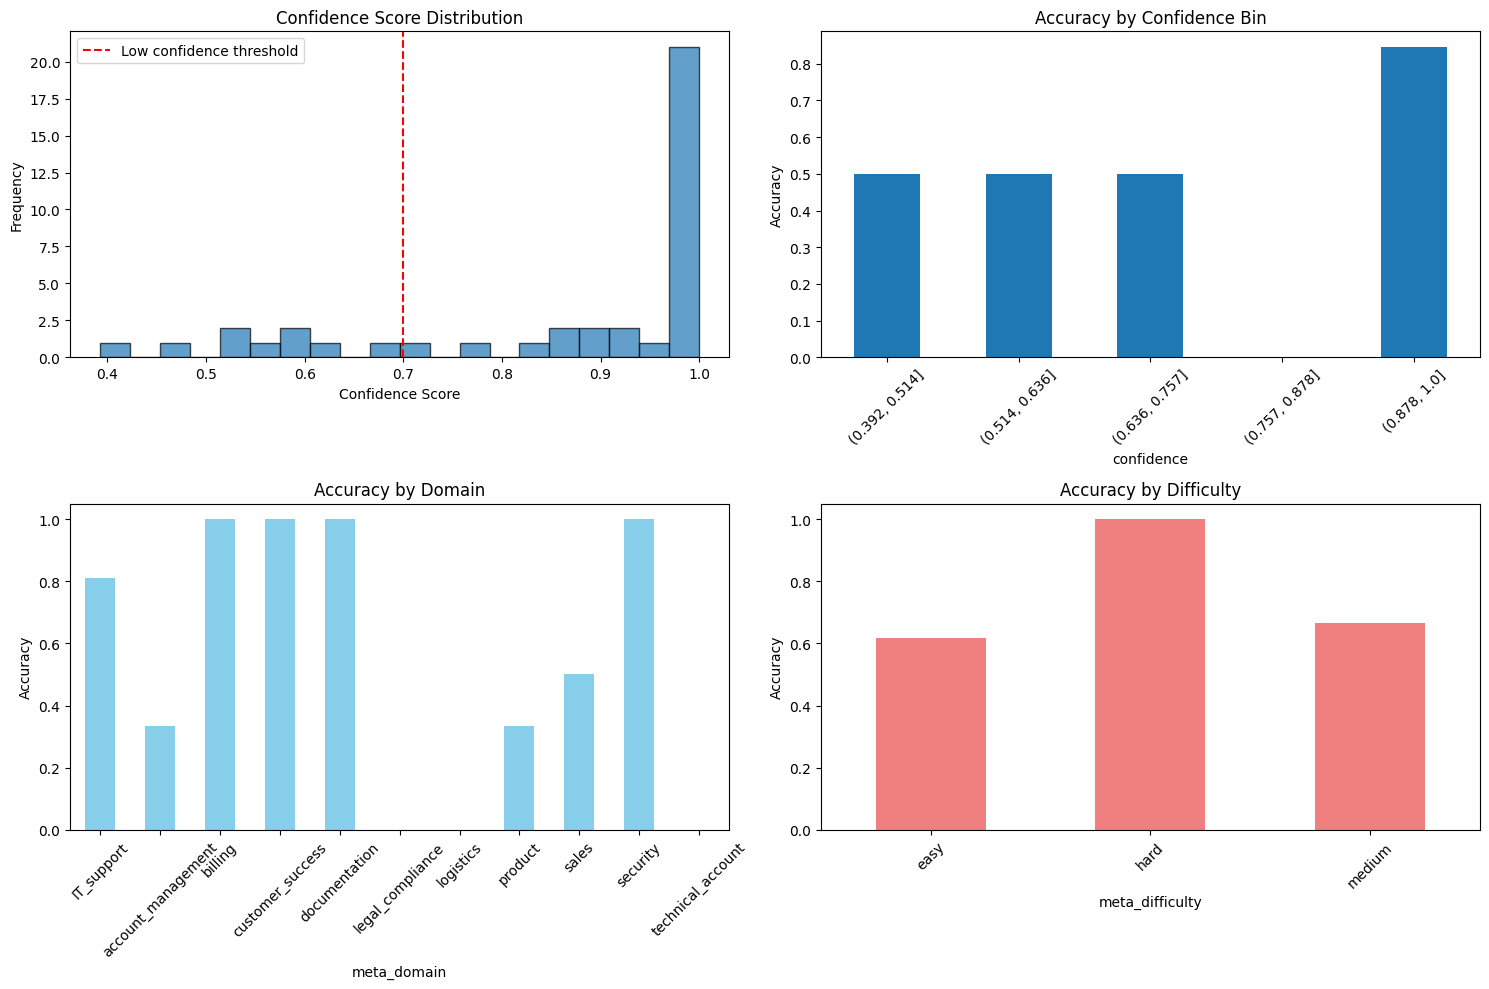

In [21]:
import ast
import json
import re


# Extract metadata
def extract_metadata(row):
    try:
        specifics = ast.literal_eval(row['specifics'])
        metadata = json.loads(specifics.get('metadata', '{}'))
        return pd.Series({
            'meta_category': metadata.get('category', 'unknown'),
            'meta_difficulty': metadata.get('difficulty', 'unknown'),
            'meta_domain': metadata.get('domain', 'unknown')
        })
    except:
        return pd.Series({'meta_category': 'unknown', 'meta_difficulty': 'unknown', 'meta_domain': 'unknown'})

# Add missing columns
results_df['pred_class'] = results_df['predictions'].apply(extract_class_value)
results_df['gold_class'] = results_df['gold'].apply(extract_class_value)
results_df['correct'] = results_df['pred_class'] == results_df['gold_class']
results_df[['meta_category', 'meta_difficulty', 'meta_domain']] = results_df.apply(extract_metadata, axis=1)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(results_df['confidence'], bins=20, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0.7, color='red', linestyle='--', label='Low confidence threshold')
axes[0, 0].set_title('Confidence Score Distribution')
axes[0, 0].set_xlabel('Confidence Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

confidence_bins = pd.cut(results_df['confidence'], bins=5)
accuracy_by_conf = results_df.groupby(confidence_bins, observed=True)['correct'].mean()
accuracy_by_conf.plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Accuracy by Confidence Bin')
axes[0, 1].set_ylabel('Accuracy')

domain_perf = results_df.groupby('meta_domain')['correct'].mean()
domain_perf.plot(kind='bar', ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Accuracy by Domain')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

difficulty_perf = results_df.groupby('meta_difficulty')['correct'].mean()
difficulty_perf.plot(kind='bar', ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_title('Accuracy by Difficulty')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Stratified Analysis and Cross-Tabulation Intelligence


Aggregate metrics mask critical performance patterns that determine real-world model reliability. This systematic stratified analysis framework dissects model behavior across metadata dimensions, revealing interaction effects and failure modes invisible to traditional evaluation approaches.

The analysis progresses through three complementary diagnostic layers: **stratified confidence analysis** identifies calibration failures across data segments, **cross-tabulation analysis** reveals interaction effects between confidence and metadata dimensions, and **problematic segment identification** prioritizes intervention targets based on failure severity.

This multi-dimensional approach transforms evaluation from reactive performance measurement into proactive failure mode detection, enabling precise, targeted model improvements rather than broad optimization efforts. By systematically examining confidence-accuracy relationships across domain, difficulty, and category intersections, teams can identify exactly where models fail and why, converting scattered performance issues into structured improvement roadmaps.

The framework addresses three critical evaluation limitations: **calibration assessment** across heterogeneous data segments, **interaction effect detection** between model confidence and task characteristics, and **intervention prioritization** based on failure severity and statistical significance. This systematic approach enables data-driven optimization strategies that maximize improvement impact while minimizing resource expenditure.

### Confidence Distribution by Metadata

The stratified confidence analysis performs systematic model calibration assessment across metadata dimensions. This diagnostic framework segments evaluation results by difficulty, domain, and category, calculating three critical metrics for each segment:

- **Average confidence score** - Quantifies model certainty about predictions
- **Sample count** - Ensures statistical significance of findings  
- **Accuracy rate** - Measures actual prediction correctness

Well-calibrated models exhibit consistent confidence-accuracy relationships across all data segments. Significant deviations reveal systematic biases, training data imbalances, or calibration failures that aggregate metrics cannot detect.

**Calibration Assessment**: Models should demonstrate proportional confidence-accuracy alignment. High confidence predictions should achieve higher accuracy rates, with this relationship holding consistently across different data segments.

**Failure Mode Identification**: Segments showing high confidence but low accuracy represent dangerous overconfident predictions that could mislead users or compromise downstream system reliability.

**Resource Allocation Intelligence**: Low-performing segments with sufficient sample sizes indicate precisely where targeted improvements (data augmentation, domain-specific fine-tuning) would yield maximum impact.



In [22]:
print("=" * 70)
print("CONFIDENCE DISTRIBUTION BY METADATA")
print("=" * 70)

# Confidence by difficulty
print("\n=== Confidence by Difficulty ===")
for difficulty in ['easy', 'medium', 'hard']:
    subset = results_df[results_df['meta_difficulty'] == difficulty]
    if len(subset) > 0:
        print(f"{difficulty:8s}: avg confidence = {subset['confidence'].mean():.3f}, "
              f"count = {len(subset):3d}, accuracy = {subset['correct'].mean():.1%}")

# Confidence by domain
print("\n=== Confidence by Domain ===")
for domain in sorted(results_df['meta_domain'].unique()):
    subset = results_df[results_df['meta_domain'] == domain]
    if len(subset) > 0:
        print(f"{domain:15s}: avg confidence = {subset['confidence'].mean():.3f}, "
              f"count = {len(subset):3d}, accuracy = {subset['correct'].mean():.1%}")

# Confidence by category
print("\n=== Confidence by Category ===")
for category in sorted(results_df['meta_category'].unique()):
    subset = results_df[results_df['meta_category'] == category]
    if len(subset) > 0:
        print(f"{category:20s}: avg confidence = {subset['confidence'].mean():.3f}, "
              f"count = {len(subset):3d}, accuracy = {subset['correct'].mean():.1%}")

CONFIDENCE DISTRIBUTION BY METADATA

=== Confidence by Difficulty ===
easy    : avg confidence = 0.869, count =  21, accuracy = 61.9%
medium  : avg confidence = 0.860, count =  15, accuracy = 66.7%
hard    : avg confidence = 0.845, count =   4, accuracy = 100.0%

=== Confidence by Domain ===
IT_support     : avg confidence = 0.884, count =  21, accuracy = 81.0%
account_management: avg confidence = 0.915, count =   3, accuracy = 33.3%
billing        : avg confidence = 0.996, count =   3, accuracy = 100.0%
customer_success: avg confidence = 0.999, count =   1, accuracy = 100.0%
documentation  : avg confidence = 0.604, count =   1, accuracy = 100.0%
legal_compliance: avg confidence = 0.671, count =   1, accuracy = 0.0%
logistics      : avg confidence = 0.914, count =   2, accuracy = 0.0%
product        : avg confidence = 0.870, count =   3, accuracy = 33.3%
sales          : avg confidence = 0.702, count =   2, accuracy = 50.0%
security       : avg confidence = 0.820, count =   2, accuracy

**Key Diagnostic Patterns**

The analysis reveals four critical calibration patterns:

1. **Confidence-Accuracy Misalignment**: High confidence combined with low accuracy indicates dangerous overconfidence requiring temperature scaling or confidence penalty training
2. **Conservative Calibration**: Low confidence with high accuracy suggests overly conservative models that may benefit from confidence boosting techniques
3. **Training Data Quality Issues**: Large accuracy gaps between domains indicate unbalanced training data requiring targeted augmentation
4. **Systematic Bias Detection**: Consistent underperformance in specific segments reveals model limitations requiring architectural or training strategy adjustments

This approach transforms aggregate performance metrics into precise diagnostic intelligence, enabling targeted model improvements rather than broad, unfocused optimization efforts.

### Cross-Tabulation Analysis

The cross-tabulation analysis reveals interaction effects between model confidence and metadata dimensions, identifying compound failure modes where multiple factors interact to degrade performance. This approach bins confidence scores into interpretable categories (Low: 0-0.3, Medium: 0.3-0.7, High: 0.7-1.0) and examines accuracy patterns across these intersections.

Cross-tabulation moves beyond simple averages into multidimensional performance maps, revealing how confidence calibration varies across different data characteristics. The analysis generates two critical outputs for each intersection:

- **Accuracy matrices** - Show actual performance at confidence-metadata intersections
- **Sample count matrices** - Ensure statistical significance of observed patterns

**Why it Matters**

**Interaction Effect Detection**: Simple stratified analysis might miss cases where confidence calibration breaks down only under specific conditions (e.g., high-confidence predictions in certain domains showing unexpectedly low accuracy).

**Calibration Validation**: Well-calibrated models should show consistent accuracy improvements as confidence increases, regardless of metadata characteristics. Deviations indicate systematic calibration failures.

**Compound Failure Identification**: Some failure modes only emerge when multiple factors combine (e.g., medium-confidence predictions in hard cases performing worse than expected).



In [23]:
print("\n" + "=" * 70)
print("CROSS-TABULATION: CONFIDENCE × CORRECTNESS × METADATA")
print("=" * 70)

# Create confidence bins
results_df['conf_bin'] = pd.cut(results_df['confidence'], 
                                 bins=[0, 0.3, 0.7, 1.0], 
                                 labels=['Low', 'Medium', 'High'])

# Cross-tab: Confidence vs Difficulty (showing accuracy)
print("\n=== Accuracy by Confidence Level × Difficulty ===")
crosstab_diff = pd.crosstab(results_df['conf_bin'], 
                             results_df['meta_difficulty'],
                             values=results_df['correct'],
                             aggfunc='mean')
print(crosstab_diff.fillna('-').round(3))

# Show counts for context
print("\n=== Sample Count by Confidence Level × Difficulty ===")
count_tab_diff = pd.crosstab(results_df['conf_bin'], 
                              results_df['meta_difficulty'])
print(count_tab_diff)

# Cross-tab: Confidence vs Domain (showing accuracy)
print("\n=== Accuracy by Confidence Level × Domain (Top Domains) ===")
# Only show domains with at least 3 samples
domain_counts = results_df['meta_domain'].value_counts()
top_domains = domain_counts[domain_counts >= 3].index.tolist()

if top_domains:
    filtered_df = results_df[results_df['meta_domain'].isin(top_domains)]
    crosstab_domain = pd.crosstab(filtered_df['conf_bin'], 
                                   filtered_df['meta_domain'],
                                   values=filtered_df['correct'],
                                   aggfunc='mean')
    print(crosstab_domain.fillna('-').round(3))
    
    print("\n=== Sample Count by Confidence Level × Domain (Top Domains) ===")
    count_tab_domain = pd.crosstab(filtered_df['conf_bin'], 
                                    filtered_df['meta_domain'])
    print(count_tab_domain)
else:
    print("Not enough samples per domain for meaningful cross-tabulation")


CROSS-TABULATION: CONFIDENCE × CORRECTNESS × METADATA

=== Accuracy by Confidence Level × Difficulty ===
meta_difficulty   easy  hard  medium
conf_bin                            
Medium           0.600   1.0   0.000
High             0.625   1.0   0.833

=== Sample Count by Confidence Level × Difficulty ===
meta_difficulty  easy  hard  medium
conf_bin                           
Medium              5     1       3
High               16     3      12

=== Accuracy by Confidence Level × Domain (Top Domains) ===
meta_domain  IT_support account_management billing  product
conf_bin                                                   
Medium            0.500                  -       -      0.0
High              0.882           0.333333     1.0      0.5

=== Sample Count by Confidence Level × Domain (Top Domains) ===
meta_domain  IT_support  account_management  billing  product
conf_bin                                                     
Medium                4                   0        0     

**Key Insights**

The cross-tabulation reveals four critical interaction patterns:

1. **Confidence-Domain Interactions**: Domains where high confidence doesn't correlate with high accuracy indicate domain-specific overconfidence requiring targeted calibration
2. **Difficulty-Confidence Misalignment**: Cases where confidence patterns don't match difficulty levels suggest either labeling inconsistencies or model biases
3. **Sparse Cell Analysis**: Empty or low-count cells reveal data distribution issues and potential blind spots in model training
4. **Calibration Consistency**: Systematic deviations from expected confidence-accuracy relationships across metadata dimensions indicate fundamental calibration problems

**Actionable Intelligence from Cross-Tabulation**

This analysis enables precise intervention targeting:
- **Domain-Specific Calibration**: Apply temperature scaling selectively to domains showing confidence-accuracy misalignment
- **Training Data Rebalancing**: Address sparse cells through targeted data collection
- **Architecture Modifications**: Consider domain-aware confidence estimation for consistently miscalibrated segments
- **Evaluation Protocol Refinement**: Identify metadata combinations requiring additional validation

Cross-tabulation changes evaluation from univariate analysis into systematic interaction detection, revealing failure modes invisible to aggregate metrics or simple stratification.

### Problematic Segment Identification 

The problematic segment analysis identifies the most critical failure modes by aggregating performance across domain-difficulty intersections. This targeted approach filters for segments exhibiting both low confidence (<0.5) and low accuracy (<0.3) - the most dangerous combination indicating fundamental model failures.

The code performs multi-dimensional aggregation across domain and difficulty metadata, calculating three key metrics for each intersection:

- **Average confidence** - Model certainty levels for the segment
- **Accuracy rate** - Actual performance within the segment  
- **Sample count** - Statistical significance and intervention priority

**Why Problematic Segment Detection Matters**

**Critical Failure Identification**: Segments with both low confidence and low accuracy represent the most severe model failures - cases where the model both performs poorly and lacks awareness of its limitations.

**Intervention Prioritization**: Limited resources require strategic allocation. This analysis identifies precisely which domain-difficulty combinations need immediate attention based on failure severity and sample size.

**Risk Assessment**: Low confidence + low accuracy segments pose the highest risk in production systems, as they represent unpredictable model behavior in critical scenarios.




In [24]:
print("\n" + "=" * 70)
print("PROBLEMATIC SEGMENTS (Low Confidence + Low Accuracy)")
print("=" * 70)

# Aggregate by domain and difficulty
segment_analysis = results_df.groupby(['meta_domain', 'meta_difficulty']).agg({
    'confidence': 'mean',
    'correct': 'mean',
    'example': 'count'
}).round(3)

segment_analysis.columns = ['avg_confidence', 'accuracy', 'count']

# Filter for problematic segments
problematic = segment_analysis[
    (segment_analysis['avg_confidence'] < 0.5) & 
    (segment_analysis['accuracy'] < 0.3)
]

if len(problematic) > 0:
    print("\nSegments needing attention:")
    print(problematic.sort_values('accuracy'))
    
    print("\n=== Recommendations ===")
    for (domain, difficulty), row in problematic.iterrows():
        print(f"\n{domain} / {difficulty}:")
        print(f"  - {row['count']} examples with {row['accuracy']:.1%} accuracy")
        print(f"  - Average confidence: {row['avg_confidence']:.3f}")
        print(f"  - Action: Add more training data or improve prompts for this segment")
else:
    print("\nNo severely problematic segments found.")
    print("All segments have either reasonable confidence or accuracy.")

# Show all segments for comparison
print("\n=== All Segments Overview ===")
print(segment_analysis.sort_values('accuracy'))


PROBLEMATIC SEGMENTS (Low Confidence + Low Accuracy)

Segments needing attention:
                                   avg_confidence  accuracy  count
meta_domain       meta_difficulty                                 
technical_account medium                    0.473       0.0      1

=== Recommendations ===

technical_account / medium:
  - 1.0 examples with 0.0% accuracy
  - Average confidence: 0.473
  - Action: Add more training data or improve prompts for this segment

=== All Segments Overview ===
                                    avg_confidence  accuracy  count
meta_domain        meta_difficulty                                 
legal_compliance   medium                    0.671     0.000      1
logistics          easy                      0.914     0.000      2
technical_account  medium                    0.473     0.000      1
account_management easy                      0.915     0.333      3
product            easy                      0.870     0.333      3
sales             

**Strategic Diagnostics**

The analysis reveals four intervention categories:

1. **Critical Segments** (Low confidence + Low accuracy): Immediate intervention required through targeted data augmentation or prompt engineering
2. **Training Gaps** (High confidence + Low accuracy): Overconfident failures requiring calibration and additional training data
3. **Conservative Performance** (Low confidence + High accuracy): Acceptable but could benefit from confidence boosting
4. **Optimal Segments** (High confidence + High accuracy): Well-functioning areas requiring no immediate intervention

**Actionable Intervention Strategies**

For each problematic segment, the analysis provides specific recommendations:

- **Data Augmentation**: Focus collection efforts on underrepresented domain-difficulty combinations
- **Prompt Engineering**: Refine instructions for specific challenging scenarios
- **Architecture Modifications**: Consider specialized components for consistently problematic segments
- **Evaluation Protocol Enhancement**: Implement additional validation for high-risk combinations

**Informed Improvement Planning**

The problematic segment analysis converts reactive debugging into proactive optimization, enabling systematic model improvement through targeted, data-driven interventions.

## Key features shown

**Metadata Passthrough**: End-to-end preservation of custom fields enables stratified analysis across domains, difficulty levels, and categories without post-hoc data joins.

**Log Probabilities**: Token-level uncertainty quantification supports confidence calibration, quality gates, and hallucination detection in production systems.

**Custom Metrics (BYOM)**: Complete evaluation pipeline control with schema validation, domain-specific metrics, and flexible pre/post-processing hooks.

**Multi-Node Scaling**: Distributed evaluation maintains deterministic results while scaling from thousands to millions of examples through simple replica configuration.

### **Data into Action**

The multi-dimensional analysis approach—combining confidence calibration assessment, cross-tabulation interaction detection, and problematic segment identification—converts scattered performance issues into structured improvement roadmaps:

- **Precision Targeting**: Identify exactly which domain-difficulty combinations require intervention
- **Resource Optimization**: Prioritize improvements based on failure severity and statistical significance
- **Risk Assessment**: Detect overconfident predictions that pose production reliability risks
- **Systematic Improvement**: Transform reactive debugging into proactive optimization planning

### **Next Steps**

1. **Deploy Evaluation Pipeline**: Configure your dataset and custom metrics using the Nova Container framework
2. **Implement Stratified Analysis**: Apply confidence-metadata segmentation to identify hidden failure modes
3. **Establish Production Monitoring**: Track calibration quality across metadata dimensions in live systems
4. **Scale Systematically**: Use multi-node configuration for comprehensive dataset evaluation
5. **Optimize Strategically**: Focus interventions on problematic segments with maximum impact potential\n
